In [448]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from pylab import rcParams
import random
import datetime
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler


from tqdm import tqdm_notebook
from tqdm import tqdm
from itertools import product

    Что день грядущий нам готовит? Построение прогноза временного ряда с использованием изученных методов
    Цель:

    В этом домашнем задании будет заниматься очень интересными прогнозами,
    которые вполне могут быть полезны для организации работы метро - попробуем построить модель,
    которая предсказывает, сколько пассажиров будут им пользоваться в ближайшее время.

    Описание/Пошаговая инструкция выполнения домашнего задания:

    Подготовка:

    Скачиваем данные по загруженности метро вот отсюда https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

    Проводим базовый EDA, вам понадобятся только 4 столбца датасета -
                traffic_volume (наша целевая переменная),
                date_time,
                holiday (является ли день некоторым праздником),
                temp (температура воздуха).

    По результатам EDA убеждаемся, что в этом временном ряду во-первых, есть дубликаты, а во-вторых, нарушена равномерность временных интервалов,
    т.е. не все значения отстоят друг от друга на 1 час - дубликаты удаляем, а временные интервалы выравниваем и заполняем пропуски при помощи линейной интерполяции
    (подсказка - в этом вам помогут функции pd.date_range, и interpolate, пример можно найти здесь - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html).

    Моделирование:
    Теперь, когда ряд выглядит более-менее адекватно, настало время прогнозировать.
    Нашей целью будет построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю (т.е, так как данные у нас дневные, модель должна предсказывать на 24*7 точек вперёд).

    Отложите последние две недели в датасете для тестирования вашей модели - на этих данных вы будете проверять финальное качество всех моделек.
    Теперь у вас осталось еще много-много наблюдений во временном ряду, исходя из графиков, трендов и т.д., попробуйте предположить,
    какие исторические данные действительно будут релевантны для прогнозов текущих значений, возможно,
    предыдущие три года уже не так сильно влияют на следующую неделю и можно значительную часть данных просто выкинуть.

    Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня.
    Строим baseline прогноз - по тем данным, которые вы решили оставить для обучения модели,
    посчитайте средние значения по часам и по дням (вам поможет data.groupby(["weekday", "hour"])["traffic_volume"].mean() и
    используйте эти значения в качестве прогноза на отложенную выборку - посчитайте метрики качества, которые вы посчитаете нужными.

    А теперь свободное творчество - попробуйте построить разные модели, которые мы с вами разбирали, и побить качество базового прогноза.
    Несколько советов:

    для SARIMA модели имеет смысл указать недельную сезонность (т.е. 24*7), чтобы она учла падения по выходным;
    попробуйте использовать температуру воздуха, как признак, в этом случае можно отдельно спрогнозировать температуру (например, используя SARIMA),
    а затем воспользоваться этими предсказаниями, когда будете делать прогноз для отложенной части выборки.

    Наконец, когда вы подберете модель, устраивающую вас по качеству на отложенной выборке, используйте эту выборку для построения прогноза на следующую неделю и
    попробуйте построить доверительные интервалы для этого прогноза.

    Теперь вы круто разбираетесь в прогнозировании и временных рядах :)


In [7]:
Raw_data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [8]:
Raw_data

holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
0        None  288.28      0.0      0.0          40        Clouds   
1        None  289.36      0.0      0.0          75        Clouds   
2        None  289.58      0.0      0.0          90        Clouds   
3        None  290.13      0.0      0.0          90        Clouds   
4        None  291.14      0.0      0.0          75        Clouds   
...       ...     ...      ...      ...         ...           ...   
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0          90  Thunderstorm   
48202    None  282.09      0.0      0.0          90        Clouds   
48203    None  282.12      0.0      0.0          90        Clouds   

          weather_description            date_time  traffic_volume  
0            scattered clouds  2012-10-02 09:00:00            5545  
1               broken clouds  2012-10-02 10:00:00            4516  
2             overcast clouds  2012-10-02 11:00:00            4767  
3             overcast clouds  2012-10-02 12:00:00            5026  
4               broken clouds  2012-10-02 13:00:00            4918  
...                       ...                  ...             ...  
48199           broken clouds  2018-09-30 19:00:00            3543  
48200         overcast clouds  2018-09-30 20:00:00            2781  
48201  proximity thunderstorm  2018-09-30 21:00:00            2159  
48202         overcast clouds  2018-09-30 22:00:00            1450  
48203         overcast clouds  2018-09-30 23:00:00             954  

[48204 rows x 9 columns]

In [9]:
TS_df = Raw_data[['traffic_volume', 'date_time', 'holiday', 'temp']].copy()

In [10]:
TS_df = TS_df.drop_duplicates()

In [11]:
TS_df

traffic_volume            date_time holiday    temp
0                5545  2012-10-02 09:00:00    None  288.28
1                4516  2012-10-02 10:00:00    None  289.36
2                4767  2012-10-02 11:00:00    None  289.58
3                5026  2012-10-02 12:00:00    None  290.13
4                4918  2012-10-02 13:00:00    None  291.14
...               ...                  ...     ...     ...
48199            3543  2018-09-30 19:00:00    None  283.45
48200            2781  2018-09-30 20:00:00    None  282.76
48201            2159  2018-09-30 21:00:00    None  282.73
48202            1450  2018-09-30 22:00:00    None  282.09
48203             954  2018-09-30 23:00:00    None  282.12

[40653 rows x 4 columns]

In [12]:
type(TS_df['traffic_volume'][0])

numpy.int64

In [13]:
type(TS_df['date_time'][0])

str

In [14]:
TS_df['date_time'] = pd.to_datetime(TS_df['date_time']) # приведём колонку 'date_time' к формату pandas._libs.tslibs.timestamps.Timestamp

In [15]:
type(TS_df['date_time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
TS_df['temp'] = TS_df['temp'].astype(float) # приведём колонку 'temp' к формату float

array([[<AxesSubplot:title={'center':'traffic_volume'}>,
        <AxesSubplot:title={'center':'date_time'}>,
        <AxesSubplot:title={'center':'temp'}>]], dtype=object)

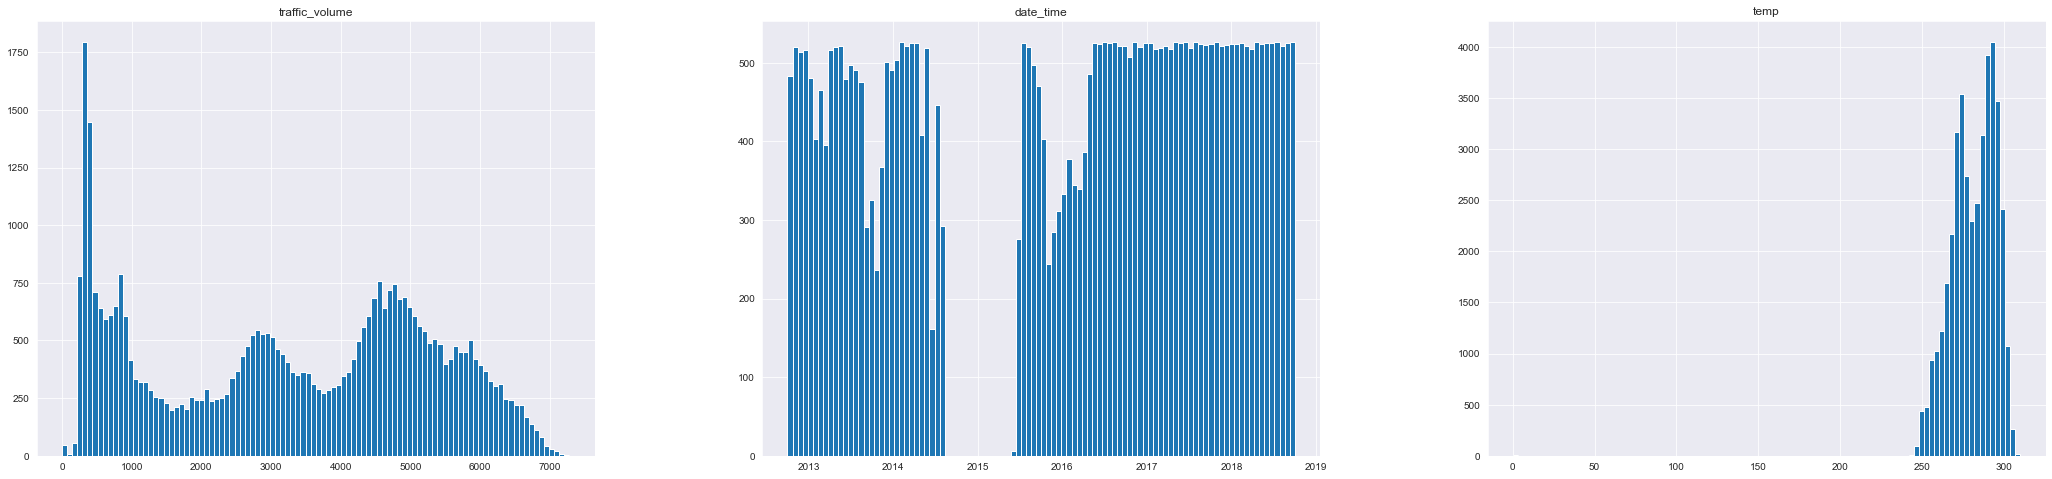

In [17]:
TS_df.hist(bins=100, figsize=(36,8), layout=(1, 3)) # посмотрим на простую гистограмму нашего датасета
#видим, что в колонке 'traffic_volume' мало значений примерно до 100 и после 7000 по Х; большой пробел в колонке 'date_time' отсутствие данных размером в год; в колонке 'temp' значения смещенны к зоне > 230;

array([[<AxesSubplot:title={'center':'traffic_volume'}>,
        <AxesSubplot:title={'center':'date_time'}>,
        <AxesSubplot:title={'center':'temp'}>]], dtype=object)

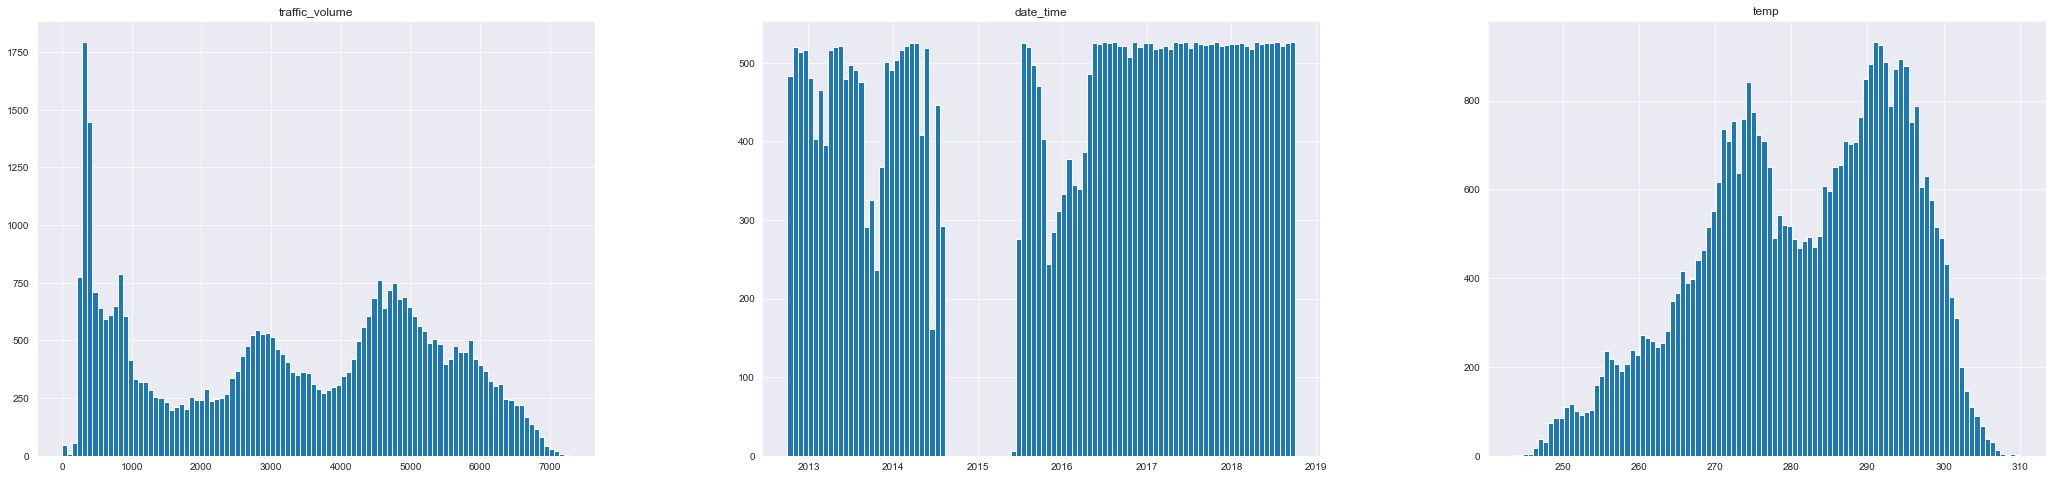

In [16]:
TS_df.loc[TS_df['temp'] > 240].hist(bins=100, figsize=(36,8), layout=(1, 3))

array([[<AxesSubplot:title={'center':'traffic_volume'}>,
        <AxesSubplot:title={'center':'date_time'}>,
        <AxesSubplot:title={'center':'temp'}>]], dtype=object)

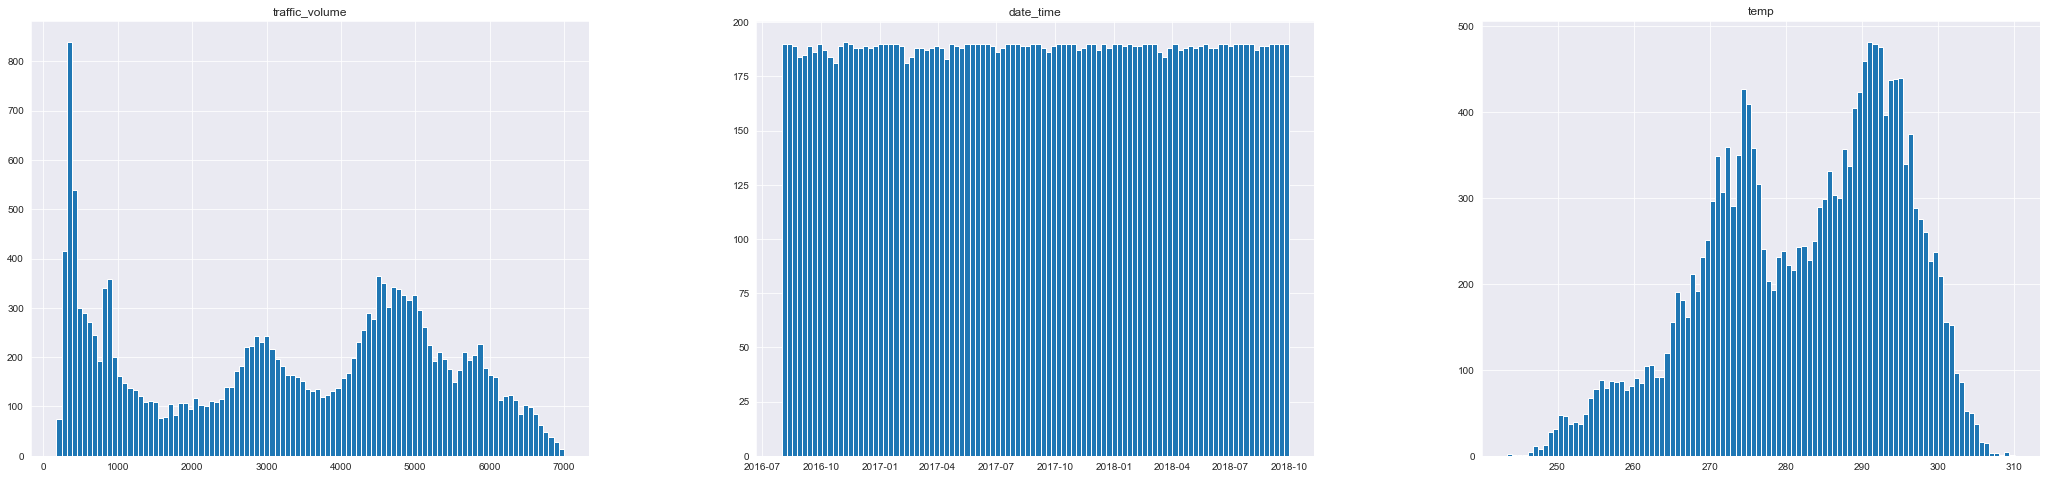

In [17]:
TS_df.query('traffic_volume < 7000  & traffic_volume > 170 & temp > 0 & date_time >= datetime.datetime(2016, 8, 1)').hist(bins=100, figsize=(36,8), layout=(1, 3))

In [88]:
'''не все значения отстоят друг от друга на 1 час - дубликаты удаляем, а временные интервалы выравниваем'''

In [18]:
date_range = pd.date_range(start=TS_df['date_time'].min(), end=TS_df['date_time'].max(), freq='1H')
date_range_df = pd.DataFrame({'date_time': date_range})

In [19]:
TS_df = pd.merge(date_range_df, TS_df, how='left', on='date_time')

array([[<AxesSubplot:title={'center':'date_time'}>,
        <AxesSubplot:title={'center':'traffic_volume'}>,
        <AxesSubplot:title={'center':'temp'}>]], dtype=object)

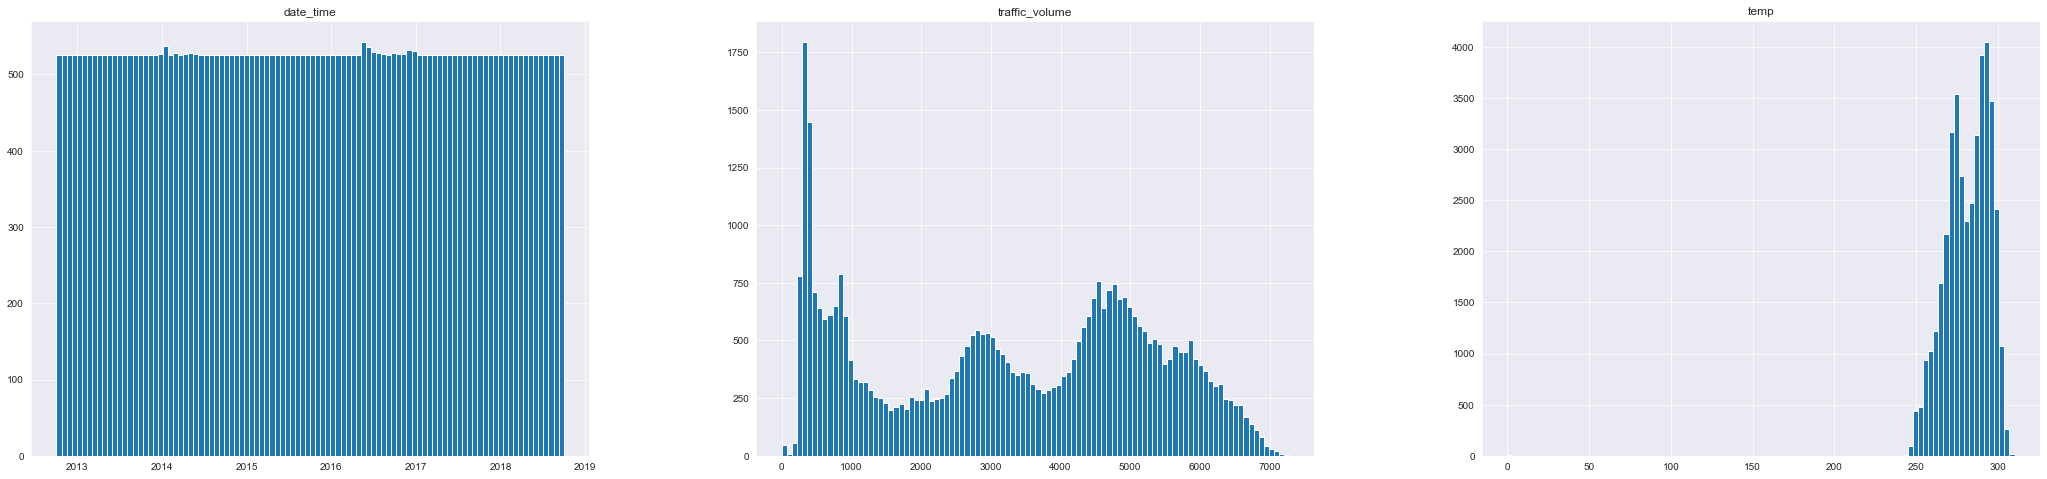

In [20]:
TS_df.hist(bins=100, figsize=(36,8), layout=(1, 3))

In [21]:
TS_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52629 entries, 0 to 52628
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_time       52629 non-null  datetime64[ns]
 1   traffic_volume  40653 non-null  float64       
 2   holiday         40653 non-null  object        
 3   temp            40653 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 2.0+ MB


In [185]:
''' заполняем пропуски при помощи линейной интерполяции '''

' заполняем пропуски при помощи линейной интерполяции '

In [21]:
TS_df[['temp', 'traffic_volume']] = TS_df[['temp', 'traffic_volume']].interpolate()

In [22]:
TS_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52629 entries, 0 to 52628
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_time       52629 non-null  datetime64[ns]
 1   traffic_volume  52629 non-null  float64       
 2   holiday         40653 non-null  object        
 3   temp            52629 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 2.0+ MB


In [ ]:
'''Теперь у вас осталось еще много-много наблюдений во временном ряду, исходя из графиков, трендов и т.д., попробуйте предположить,
    какие исторические данные действительно будут релевантны для прогнозов текущих значений, возможно,
    предыдущие три года уже не так сильно влияют на следующую неделю и можно значительную часть данных просто выкинуть.

думаю, что имеет смысл обрезать датасет следующим образом - 'traffic_volume < 7000  & traffic_volume > 170 & temp > 0 & date_time >= datetime.datetime(2016, 8, 1)' '''

In [23]:
Pruned_TS_df = TS_df.query('traffic_volume < 7000  & traffic_volume > 170 & temp > 230 & date_time >= datetime.datetime(2016, 8, 1)').copy()

In [26]:
Pruned_TS_df.to_csv('Pruned_TS_df.csv', index=False) # save dataset

In [3]:
# Pruned_TS_df = pd.read_csv('Pruned_TS_df.csv')

In [4]:
Pruned_TS_df["holiday"].value_counts()

None                         18835
State Fair                       3
Labor Day                        3
Columbus Day                     2
Veterans Day                     2
Thanksgiving Day                 2
Christmas Day                    2
New Years Day                    2
Martin Luther King Jr Day        2
Washingtons Birthday             2
Memorial Day                     2
Independence Day                 2
Name: holiday, dtype: int64

array([[<AxesSubplot:title={'center':'date_time'}>,
        <AxesSubplot:title={'center':'traffic_volume'}>,
        <AxesSubplot:title={'center':'temp'}>]], dtype=object)

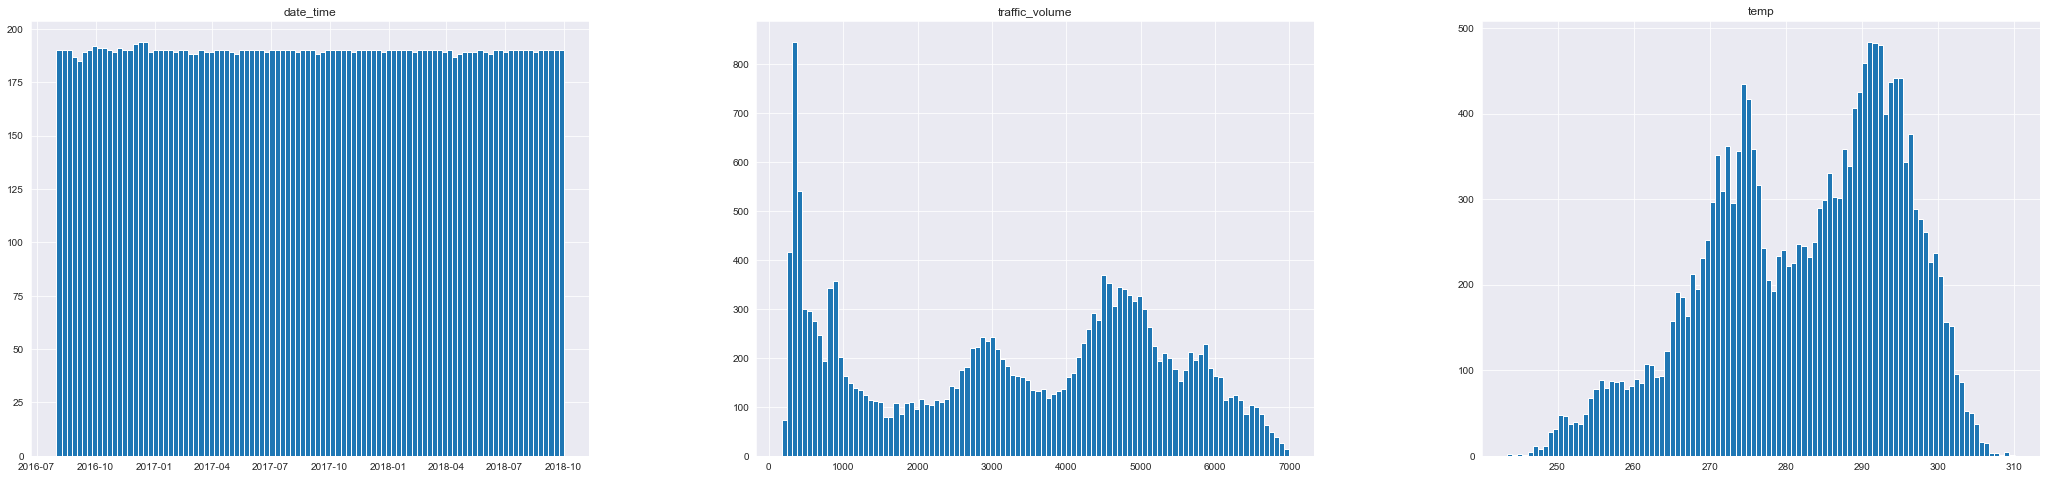

In [27]:
Pruned_TS_df.hist(bins=100, figsize=(36,8), layout=(1, 3))

    Моделирование:
    Теперь, когда ряд выглядит более-менее адекватно, настало время прогнозировать.
    Нашей целью будет построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю (т.е, так как данные у нас дневные, модель должна предсказывать на 24*7 точек вперёд).

    Отложите последние две недели в датасете для тестирования вашей модели - на этих данных вы будете проверять финальное качество всех моделек.


    Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня.
    Строим baseline прогноз - по тем данным, которые вы решили оставить для обучения модели,
    посчитайте средние значения по часам и по дням (вам поможет data.groupby(["weekday", "hour"])["traffic_volume"].mean() и
    используйте эти значения в качестве прогноза на отложенную выборку - посчитайте метрики качества, которые вы посчитаете нужными.

In [ ]:
''' Отложите последние две недели в датасете для тестирования вашей модели - на этих данных вы будете проверять финальное качество всех моделек. '''

In [28]:
Pruned_TS_df['date_time'].sort_values(ascending=True)

33626   2016-08-01 00:00:00
33627   2016-08-01 01:00:00
33628   2016-08-01 02:00:00
33629   2016-08-01 03:00:00
33630   2016-08-01 04:00:00
                ...        
52624   2018-09-30 19:00:00
52625   2018-09-30 20:00:00
52626   2018-09-30 21:00:00
52627   2018-09-30 22:00:00
52628   2018-09-30 23:00:00
Name: date_time, Length: 18973, dtype: datetime64[ns]

# Train-test split

In [24]:
Test_Pruned_TS_df = Pruned_TS_df.query(' date_time >= datetime.datetime(2018, 8, 15) ').reset_index(drop=True).copy()

In [25]:
Train_Pruned_TS_df = Pruned_TS_df.query(' date_time < datetime.datetime(2018, 8, 15) ').reset_index(drop=True).copy()

In [202]:
''' Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня. '''

In [27]:
Train_Pruned_TS_df.loc[:,'year'] = Train_Pruned_TS_df['date_time'].dt.year
Train_Pruned_TS_df.loc[:,'month'] = Train_Pruned_TS_df['date_time'].dt.month
Train_Pruned_TS_df.loc[:,'weekday'] = Train_Pruned_TS_df['date_time'].dt.dayofweek
Train_Pruned_TS_df.loc[:,'hour'] = Train_Pruned_TS_df['date_time'].dt.hour

In [28]:
Test_Pruned_TS_df.loc[:,'year'] = Test_Pruned_TS_df['date_time'].dt.year
Test_Pruned_TS_df.loc[:,'month'] = Test_Pruned_TS_df['date_time'].dt.month
Test_Pruned_TS_df.loc[:,'weekday'] = Test_Pruned_TS_df['date_time'].dt.dayofweek
Test_Pruned_TS_df.loc[:,'hour'] = Test_Pruned_TS_df['date_time'].dt.hour

In [29]:
Test_Pruned_TS_df

date_time  traffic_volume holiday    temp  year  month  \
0    2018-08-15 00:00:00           793.0    None  295.15  2018      8   
1    2018-08-15 01:00:00           492.0    None  294.79  2018      8   
2    2018-08-15 02:00:00           335.0    None  293.79  2018      8   
3    2018-08-15 03:00:00           403.0    None  293.55  2018      8   
4    2018-08-15 04:00:00           948.0    None  292.95  2018      8   
...                  ...             ...     ...     ...   ...    ...   
1123 2018-09-30 19:00:00          3543.0    None  283.45  2018      9   
1124 2018-09-30 20:00:00          2781.0    None  282.76  2018      9   
1125 2018-09-30 21:00:00          2159.0    None  282.73  2018      9   
1126 2018-09-30 22:00:00          1450.0    None  282.09  2018      9   
1127 2018-09-30 23:00:00           954.0    None  282.12  2018      9   

      weekday  hour  
0           2     0  
1           2     1  
2           2     2  
3           2     3  
4           2     4  
...       ...   ...  
1123        6    19  
1124        6    20  
1125        6    21  
1126        6    22  
1127        6    23  

[1128 rows x 8 columns]

<AxesSubplot:xlabel='hour', ylabel='traffic_volume'>

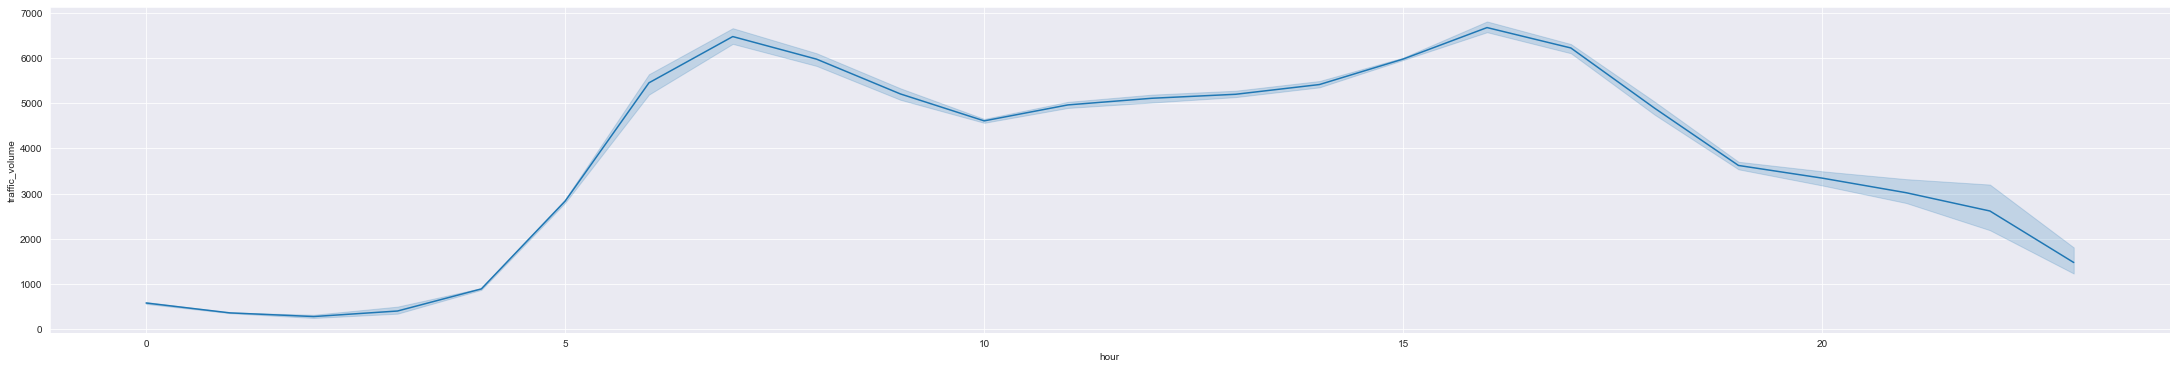

In [25]:
plt.figure(figsize=(38,6))
sns.lineplot(data=Train_Pruned_TS_df.query(' year == 2018 & month == 3 & weekday == 3 '), x = 'hour', y = 'traffic_volume')

<AxesSubplot:xlabel='date_time', ylabel='temp'>

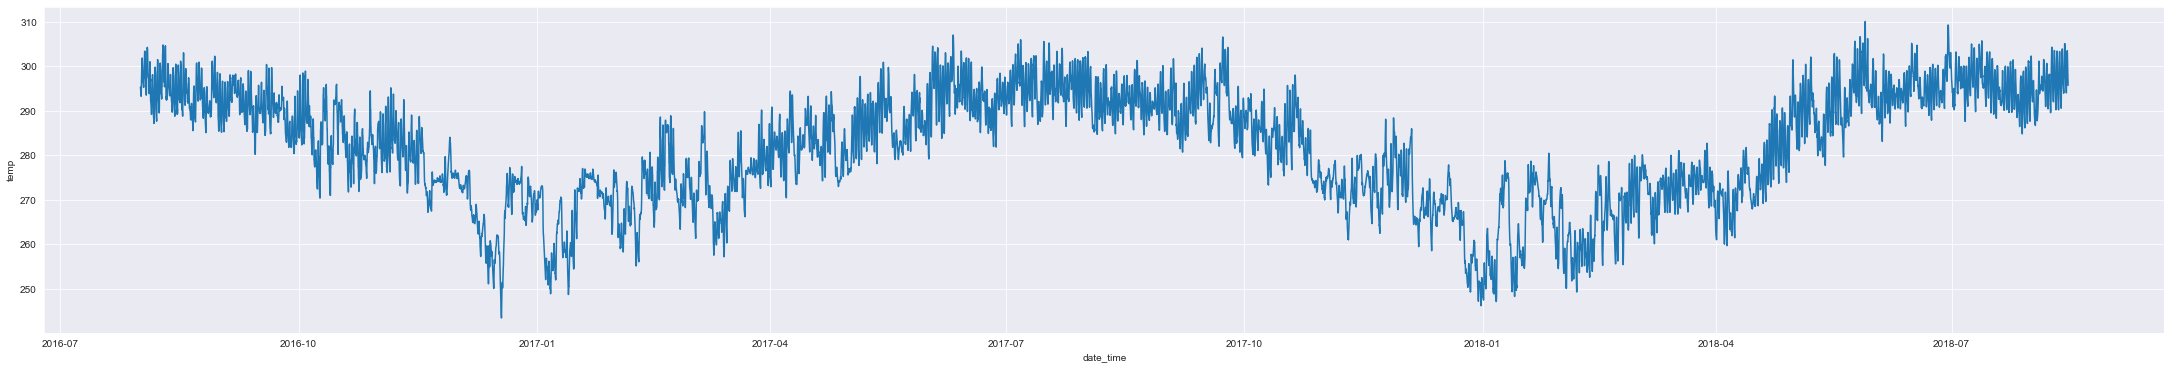

In [26]:
plt.figure(figsize=(38,6))
sns.lineplot(data=Train_Pruned_TS_df, x = 'date_time', y = 'temp')

<AxesSubplot:xlabel='date_time', ylabel='traffic_volume'>

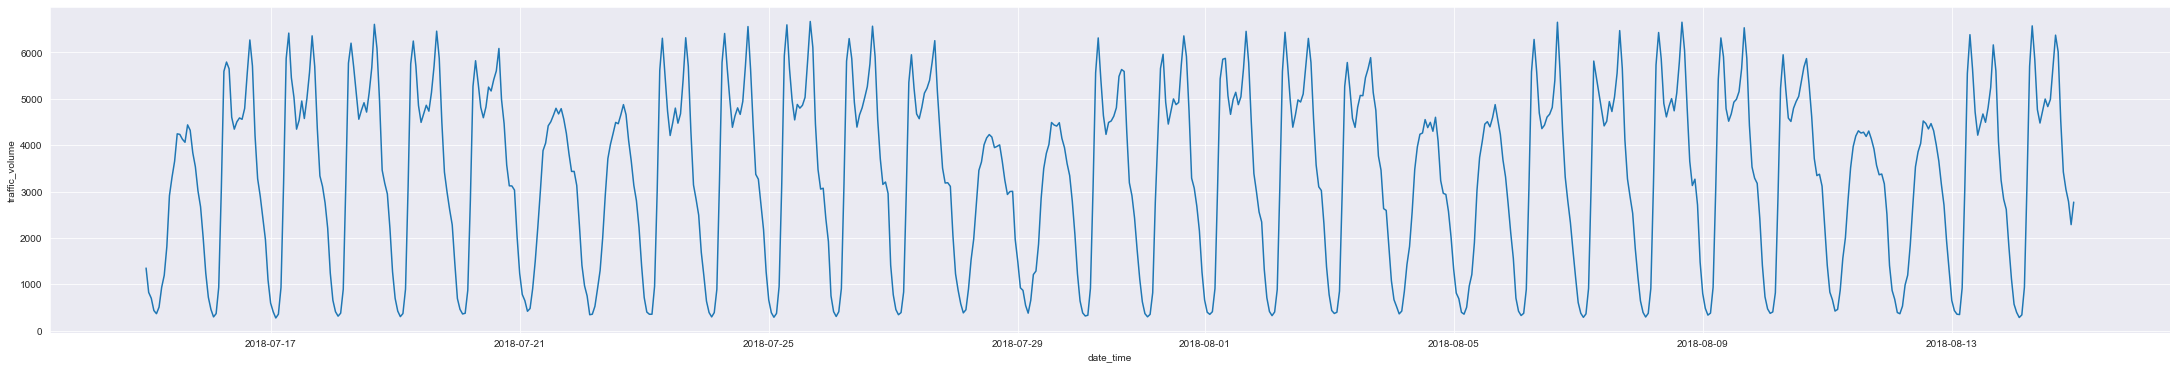

In [30]:
plt.figure(figsize=(38,6))
sns.lineplot(data=Train_Pruned_TS_df.query('date_time  >= datetime.datetime(2018, 7, 15) '), x = 'date_time', y = 'traffic_volume')

In [33]:
# Train_Pruned_TS_df.to_csv('Train_Pruned_TS_df.csv', index=False) # save dataset

In [202]:
'''
Строим baseline прогноз - по тем данным, которые вы решили оставить для обучения модели,
    посчитайте средние значения по часам и по дням (вам поможет data.groupby(["weekday", "hour"])["traffic_volume"].mean() и
    используйте эти значения в качестве прогноза на отложенную выборку - посчитайте метрики качества, которые вы посчитаете нужными.
'''

# Baseline

In [30]:
Train_Pruned_TS_df

date_time  traffic_volume holiday    temp  year  month  \
0     2016-08-01 00:00:00           705.0    None  295.30  2016      8   
1     2016-08-01 01:00:00           485.0    None  294.95  2016      8   
2     2016-08-01 02:00:00           296.0    None  294.83  2016      8   
3     2016-08-01 03:00:00           394.0    None  294.24  2016      8   
4     2016-08-01 04:00:00           886.0    None  293.70  2016      8   
...                   ...             ...     ...     ...   ...    ...   
17840 2018-08-14 19:00:00          3423.0    None  299.75  2018      8   
17841 2018-08-14 20:00:00          3046.0    None  298.74  2018      8   
17842 2018-08-14 21:00:00          2784.0    None  297.75  2018      8   
17843 2018-08-14 22:00:00          2287.0    None  296.42  2018      8   
17844 2018-08-14 23:00:00          2772.0    None  295.68  2018      8   

       weekday  hour  
0            0     0  
1            0     1  
2            0     2  
3            0     3  
4            0     4  
...        ...   ...  
17840        1    19  
17841        1    20  
17842        1    21  
17843        1    22  
17844        1    23  

[17845 rows x 8 columns]

In [31]:
baseline_df = Train_Pruned_TS_df.groupby(["weekday", "hour"])["traffic_volume"].mean().to_frame()

In [32]:
baseline_df = baseline_df.rename(columns={'traffic_volume':'traffic_volume_pred_mean'}).reset_index()

In [33]:
baseline_df

weekday  hour  traffic_volume_pred_mean
0          0     0                647.364486
1          0     1                407.607477
2          0     2                307.532710
3          0     3                357.327103
4          0     4                827.196262
..       ...   ...                       ...
163        6    19               3169.933962
164        6    20               2824.560748
165        6    21               2372.556604
166        6    22               1825.566038
167        6    23               1232.205607

[168 rows x 3 columns]

In [34]:
Train_traffic_volume_pred_mean = pd.merge(Train_Pruned_TS_df, baseline_df, how='left', on=['weekday', 'hour'])['traffic_volume_pred_mean']

In [35]:
Train_traffic_volume_pred_mean

0         647.364486
1         407.607477
2         307.532710
3         357.327103
4         827.196262
            ...     
17840    3198.149533
17841    2778.065421
17842    2691.971963
17843    2141.196262
17844    1184.626168
Name: traffic_volume_pred_mean, Length: 17845, dtype: float64

In [36]:
Train_Pruned_TS_df['traffic_volume_pred_mean'] = Train_traffic_volume_pred_mean

In [37]:
Train_Pruned_TS_df

date_time  traffic_volume holiday    temp  year  month  \
0     2016-08-01 00:00:00           705.0    None  295.30  2016      8   
1     2016-08-01 01:00:00           485.0    None  294.95  2016      8   
2     2016-08-01 02:00:00           296.0    None  294.83  2016      8   
3     2016-08-01 03:00:00           394.0    None  294.24  2016      8   
4     2016-08-01 04:00:00           886.0    None  293.70  2016      8   
...                   ...             ...     ...     ...   ...    ...   
17840 2018-08-14 19:00:00          3423.0    None  299.75  2018      8   
17841 2018-08-14 20:00:00          3046.0    None  298.74  2018      8   
17842 2018-08-14 21:00:00          2784.0    None  297.75  2018      8   
17843 2018-08-14 22:00:00          2287.0    None  296.42  2018      8   
17844 2018-08-14 23:00:00          2772.0    None  295.68  2018      8   

       weekday  hour  traffic_volume_pred_mean  
0            0     0                647.364486  
1            0     1                407.607477  
2            0     2                307.532710  
3            0     3                357.327103  
4            0     4                827.196262  
...        ...   ...                       ...  
17840        1    19               3198.149533  
17841        1    20               2778.065421  
17842        1    21               2691.971963  
17843        1    22               2141.196262  
17844        1    23               1184.626168  

[17845 rows x 9 columns]

In [38]:
print(f"Baseline MAE = {round(mae(Train_Pruned_TS_df['traffic_volume'], Train_Pruned_TS_df['traffic_volume_pred_mean']), 2)}")
print(f"Baseline MAPE = {round(mape(Train_Pruned_TS_df['traffic_volume'], Train_Pruned_TS_df['traffic_volume_pred_mean']), 2)}")
print(f"Baseline RMSE = {round(np.sqrt(mse(Train_Pruned_TS_df['traffic_volume'], Train_Pruned_TS_df['traffic_volume_pred_mean'])), 2)}")

Baseline MAE = 279.09
Baseline MAPE = 0.12
Baseline RMSE = 471.42


In [39]:
Test_traffic_volume_pred_mean = pd.merge(Test_Pruned_TS_df, baseline_df, how='left', on=['weekday', 'hour'])['traffic_volume_pred_mean']

In [40]:
Test_Pruned_TS_df['traffic_volume_pred_mean'] = Test_traffic_volume_pred_mean

In [41]:
Test_Pruned_TS_df

date_time  traffic_volume holiday    temp  year  month  \
0    2018-08-15 00:00:00           793.0    None  295.15  2018      8   
1    2018-08-15 01:00:00           492.0    None  294.79  2018      8   
2    2018-08-15 02:00:00           335.0    None  293.79  2018      8   
3    2018-08-15 03:00:00           403.0    None  293.55  2018      8   
4    2018-08-15 04:00:00           948.0    None  292.95  2018      8   
...                  ...             ...     ...     ...   ...    ...   
1123 2018-09-30 19:00:00          3543.0    None  283.45  2018      9   
1124 2018-09-30 20:00:00          2781.0    None  282.76  2018      9   
1125 2018-09-30 21:00:00          2159.0    None  282.73  2018      9   
1126 2018-09-30 22:00:00          1450.0    None  282.09  2018      9   
1127 2018-09-30 23:00:00           954.0    None  282.12  2018      9   

      weekday  hour  traffic_volume_pred_mean  
0           2     0                625.783019  
1           2     1                393.009434  
2           2     2                309.891509  
3           2     3                376.962264  
4           2     4                904.759434  
...       ...   ...                       ...  
1123        6    19               3169.933962  
1124        6    20               2824.560748  
1125        6    21               2372.556604  
1126        6    22               1825.566038  
1127        6    23               1232.205607  

[1128 rows x 9 columns]

In [42]:
print(f"Baseline MAE = {round(mae(Test_Pruned_TS_df['traffic_volume'], Test_Pruned_TS_df['traffic_volume_pred_mean']), 2)}")
print(f"Baseline MAPE = {round(mape(Test_Pruned_TS_df['traffic_volume'], Test_Pruned_TS_df['traffic_volume_pred_mean']), 2)}")
print(f"Baseline RMSE = {round(np.sqrt(mse(Test_Pruned_TS_df['traffic_volume'], Test_Pruned_TS_df['traffic_volume_pred_mean'])), 2)}")

Baseline MAE = 222.17
Baseline MAPE = 0.09
Baseline RMSE = 368.93


# End of Baseline

In [232]:
'''
А теперь свободное творчество - попробуйте построить разные модели, которые мы с вами разбирали, и побить качество базового прогноза.
    Несколько советов:

    для SARIMA модели имеет смысл указать недельную сезонность (т.е. 24*7), чтобы она учла падения по выходным;
    попробуйте использовать температуру воздуха, как признак, в этом случае можно отдельно спрогнозировать температуру (например, используя SARIMA),
    а затем воспользоваться этими предсказаниями, когда будете делать прогноз для отложенной части выборки.

    Наконец, когда вы подберете модель, устраивающую вас по качеству на отложенной выборке, используйте эту выборку для построения прогноза на следующую неделю и
    попробуйте построить доверительные интервалы для этого прогноза.
'''

## Triple Exponential Smooting (Holt-Winters)

In [347]:
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    :param series:          initial time series
    :param slen:            length of a season
    :param alpha:           Holt-Winters model coefficient
    :param beta:            Holt-Winters model coefficient
    :param gamma:           Holt-Winters model coefficient
    :param n_preds:         predictions horizon
    :param scaling_factor:  sets the width of the confidence interval by Brutlag (usually, values from 2 to 3)
    """
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum_ = 0.0
        for i in range(self.slen):
            sum_ += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum_ / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
                continue

            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

def plotHoltWinters(series, model, n_test_points=0, plot_intervals=False, plot_anomalies=False):
    """
    :param series:          Dataset with timeseries
    :type series:            pd.Series
    :param model:           HoltWinters model
    :type model:             HoltWinters
    :param plot_intervals:  Plot confidence intervals
    :type plot_intervals:    bool
    :param plot_anomalies:  Plot anomalies
    :type plot_anomalies:    bool
    """

    plt.figure(figsize=(20, 10))
    plt.plot(series.values, label = "Actual")
    plt.plot(model.result, label = "Model")
    error = mape(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] =\
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] =\
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond,
                         y2=model.LowerBond, alpha=0.2, color = "grey")

    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-n_test_points, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [349]:
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize

def timeseriesCVscore(params, series, loss_function=mse, slen=12):
    """
    Returns error on CV
    :param params:         Vector of parameters for optimization
    :type params:           (int, int, int)
    :param series:         Dataset with timeseries
    :type series:           pd.Series
    :param loss_function:  Loss function in the same from as losses from sklearn
    :type loss_function:    function
    :param slen:           Season length for Holt-Winters model
    :type slen:             int
    """
    assert type(series)==pd.Series, "series has to be pd.Series"

    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train],
                            slen=slen,
                            alpha=alpha,
                            beta=beta,
                            gamma=gamma,
                            n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

def find_optimal_HW_parameteres(data, slen):
    # initializing model parameters alpha, beta and gamma
    init_params = [0, 0, 0]
    param_bounds = ((0, 1), (0, 1), (0, 1))

    # Minimizing the loss function
    opt = minimize(timeseriesCVscore,
                   x0=init_params,
                   args=(data, mse, slen),
                   method="TNC",
                   bounds=param_bounds)

    # Take optimal values...
    alpha_final, beta_final, gamma_final = opt.x

    #print("Alpha =", alpha_final)
    #print("Beta  =", beta_final)
    #print("Gamma =", gamma_final)

    return alpha_final, beta_final, gamma_final

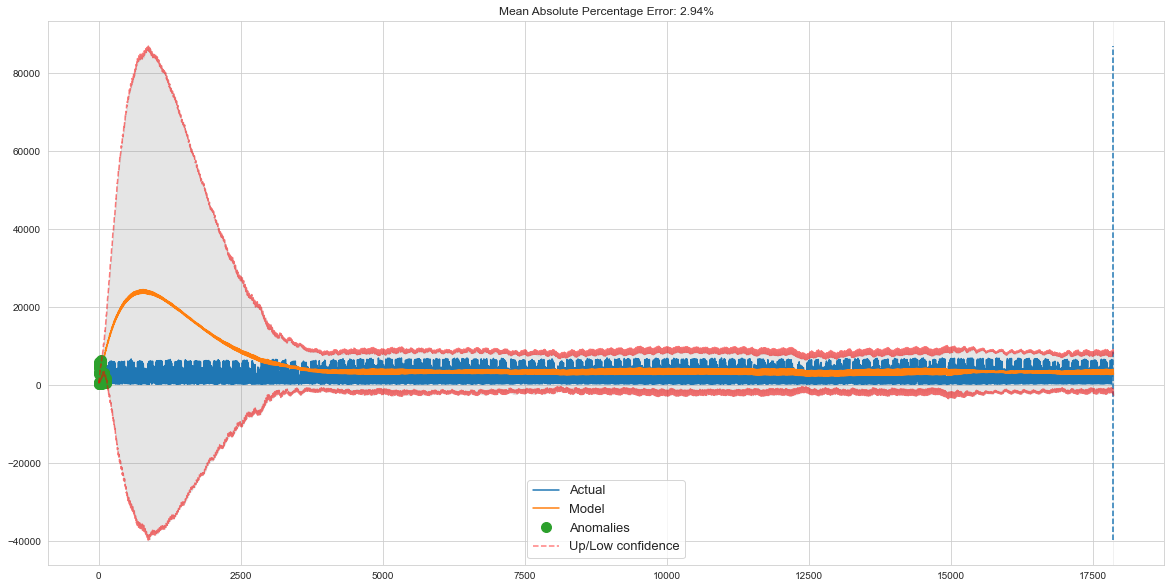

In [352]:
n_test_points = 2
data = Train_Pruned_TS_df['traffic_volume'] # leave some data for testing
SLEN = 12 # это сезонность!

alpha_final, beta_final, gamma_final = find_optimal_HW_parameteres(data, slen=SLEN)

model = HoltWinters(data,
                    slen=SLEN,
                    alpha=alpha_final,
                    beta=beta_final,
                    gamma=gamma_final,
                    n_preds=n_test_points+SLEN,
                    scaling_factor=3)
model.triple_exponential_smoothing()

plotHoltWinters(Train_Pruned_TS_df['traffic_volume'], model, n_test_points=n_test_points, plot_intervals=True, plot_anomalies=True)


## END of Triple Exponential Smooting (Holt-Winters)

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

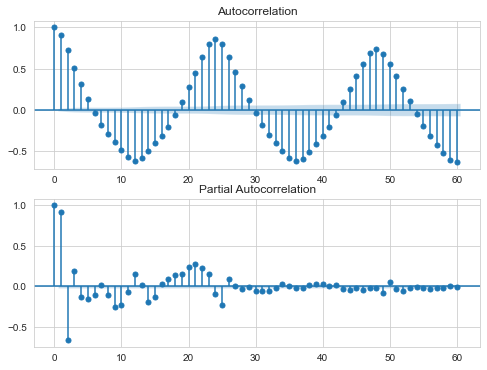

In [171]:
fig, ax = plt.subplots(2,1, figsize=(8,6))
plot_acf(Train_Pruned_TS_df.iloc[:,:]['traffic_volume'], lags=60, ax=ax[0])
plot_pacf(Train_Pruned_TS_df.iloc[:,:]['traffic_volume'], lags=60, ax=ax[1])
plt.show()

# SARIMA

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [69]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.Collecting pmdarima



  Using cached pmdarima-2.0.2-cp39-cp39-win_amd64.whl (572 kB)


In [70]:
from pmdarima.arima import auto_arima

In [82]:
p = [0, 1, 2]
d = [0, 1, 2]
q = [0, 1, 2]
P = [0, 1, 2]
D = [0, 1, 2]
Q = [0, 1, 2]
m = 7

model = auto_arima(Train_Pruned_TS_df.iloc[:,:]['traffic_volume'],
                   start_p=0, start_q=0, max_p=2, max_q=2,
                   seasonal=True, m=7, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=False,
                   random_state=42,
                   n_fits=30,
                   start_P=0, start_Q=0, max_P=2, max_Q=2,
                   information_criterion='aic')

order = model.order
seasonal_order = model.seasonal_order
# Best model:  ARIMA(2,0,2)(1,1,0)[7] intercept
# Total fit time: 281.246 seconds

 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=72501.675, Time=0.11 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=71983.178, Time=0.40 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=7.61 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=68389.240, Time=2.99 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=67753.417, Time=5.87 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=8.04 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=68131.688, Time=0.99 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=6.35 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=67392.355, Time=2.67 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=7.74 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=64566.6

In [334]:
SARIMAX_tuned_model = SARIMAX(Train_Pruned_TS_df['traffic_volume'], order=order, seasonal_order=seasonal_order)
SARIMAX_tuned_model_results = SARIMAX_tuned_model.fit(disp=-1)

In [335]:
SARIMAX_tuned_model_results_prediction = SARIMAX_tuned_model_results.get_forecast(len(Test_Pruned_TS_df['traffic_volume']))
SARIMAX_pred_mean = SARIMAX_tuned_model_results_prediction.predicted_mean
pred_ci = SARIMAX_tuned_model_results_prediction.conf_int()

In [359]:
aic = SARIMAX_tuned_model_results.aic
print("AIC: ", aic)

AIC:  281573.1767125346


In [360]:
print(SARIMAX_tuned_model_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     traffic_volume   No. Observations:                17845
Model:             SARIMAX(2, 0, 2)x(1, 1, [], 7)   Log Likelihood             -140780.588
Date:                            Thu, 16 Feb 2023   AIC                         281573.177
Time:                                    01:19:11   BIC                         281619.911
Sample:                                         0   HQIC                        281588.552
                                          - 17845                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8747      0.003    640.270      0.000       1.869       1.880
ar.L2         -0.9433      0.003   

In [48]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
    Plot time series, its ACF and PACF, calculate Dickey–Fuller test
    :param y:     Timeseries
    :param lags:  How many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout()

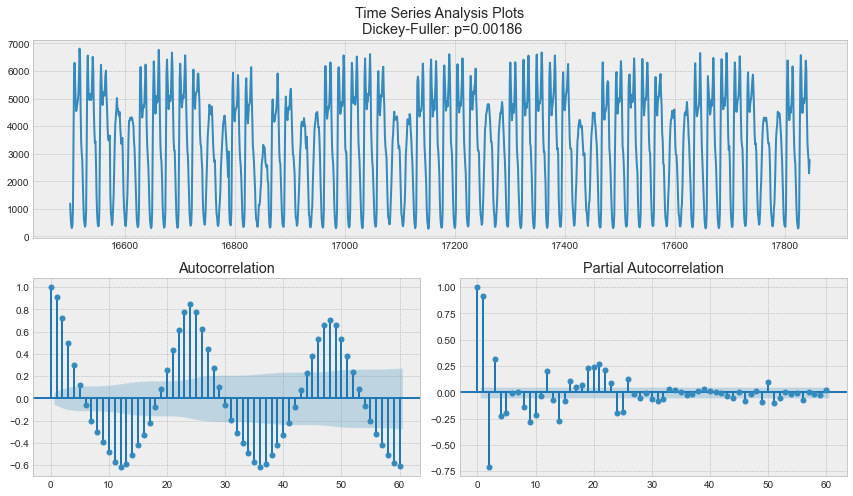

In [49]:
tsplot(Train_Pruned_TS_df.iloc[16500:,:]['traffic_volume'], lags=60)

In [ ]:
#явная периодичность через 12

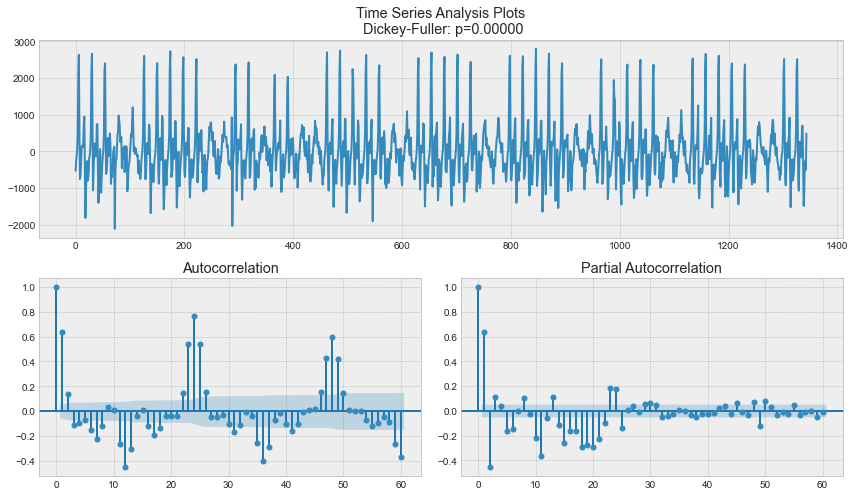

In [78]:
# Конечная разность (первого порядка, численное дифференцирование)
_diff_1 = Train_Pruned_TS_df.iloc[16500:,:]['traffic_volume'].values[1:] - Train_Pruned_TS_df.iloc[16500:,:]['traffic_volume'].values[:-1]
tsplot(_diff_1, lags=60)

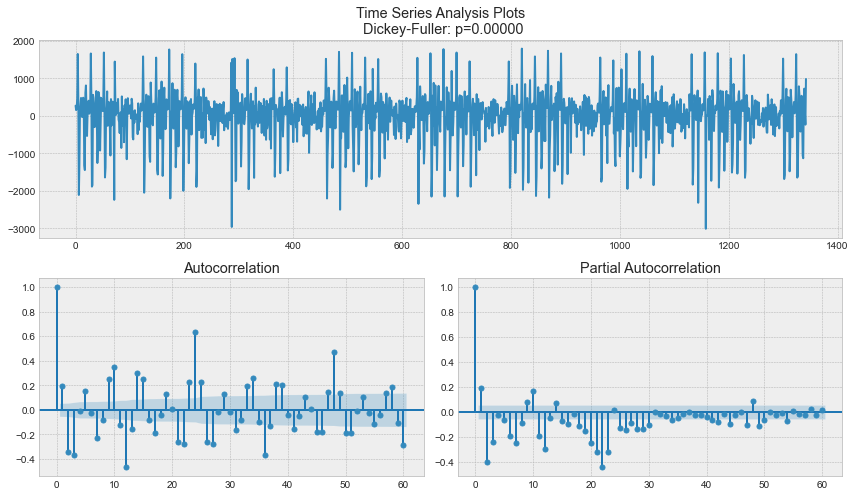

In [79]:
# Конечная разность (второго порядка)
# Автокорреляционная функция имеет сильно выраженные сезонные компоненты
_diff_2 = _diff_1[1:] - _diff_1[:-1]
tsplot(_diff_2, lags=60)

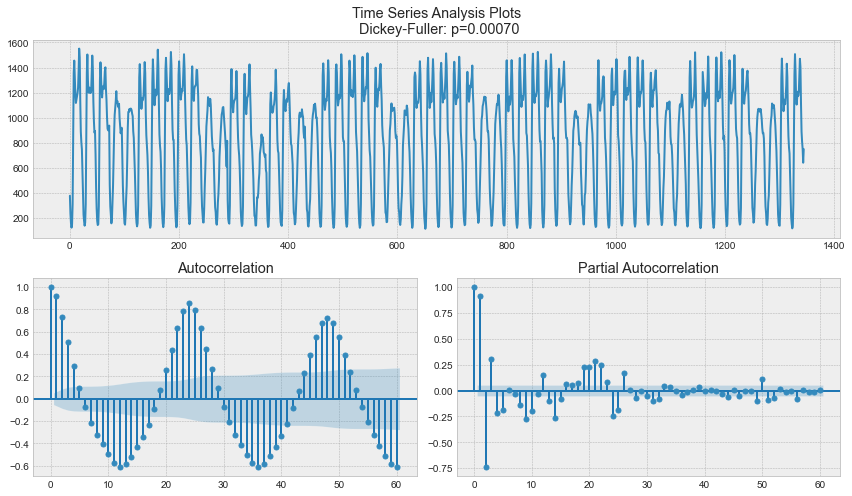

In [324]:
# Преобразование к стационарному виду (преобразование Бокса-Кокса)
# автокорреляционная функция показывает сезонность
transfromed_series_a, bc_lamb = boxcox(Train_Pruned_TS_df.iloc[16500:,:]['traffic_volume'])

tsplot(transfromed_series_a, lags=60)

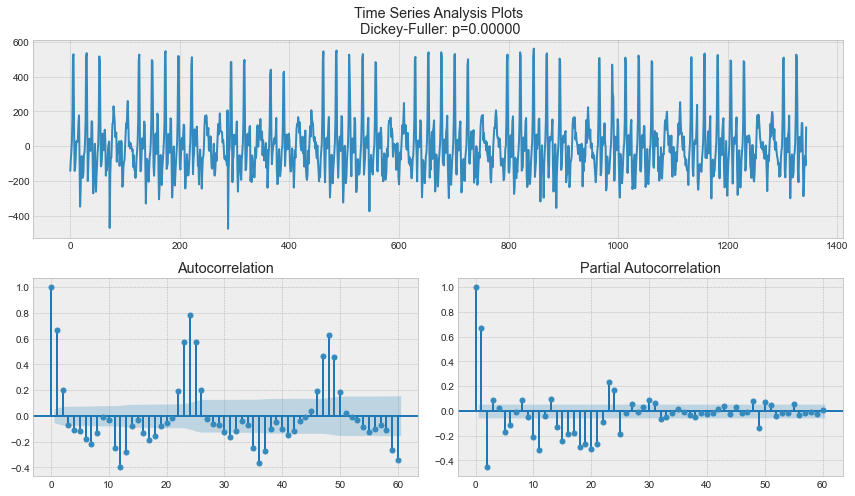

In [325]:
# Разность первого порядка (критерий Дики-Фуллера отвергает гипотезу, но в пограничных значениях)
# При этом автокорреляционная функция показывает сезонность
tsplot(transfromed_series_a[1:] - transfromed_series_a[:-1], lags=60)

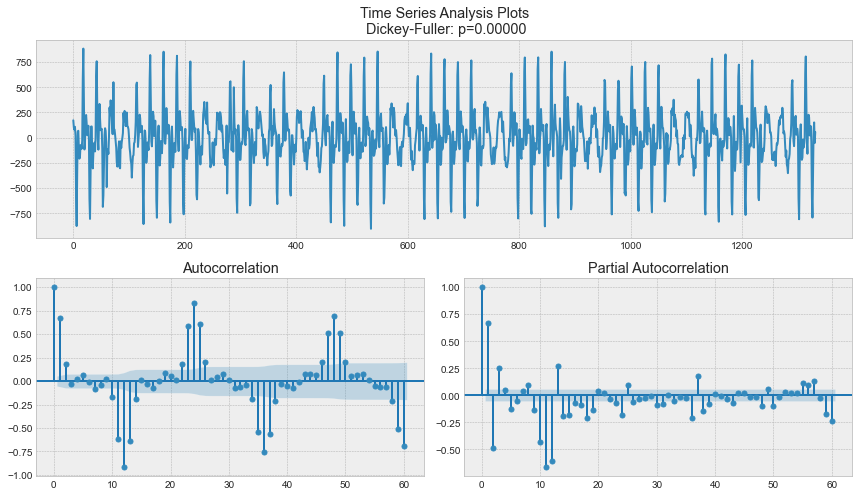

In [326]:
# + Сезонная разность
diff = transfromed_series_a[1:] - transfromed_series_a[:-1]

tsplot(diff[12:] - diff[:-12], lags=60)

In [272]:
def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    """
    Plots model vs predicted values
    :param series:   Dataset with timeseries
    :type series:     pd.DataFrame
    :param model:    Fitted SARIMA model
    :type model:      sm.tsa.statespace.SARIMAX
    :param n_steps:  Number of steps to predict in the future
    :type n_steps:    int
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mae(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(34, 8))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")

    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'],
                         y2=intervals['lower'], alpha=0.2, color = "grey")

    plt.legend()
    plt.grid(True)

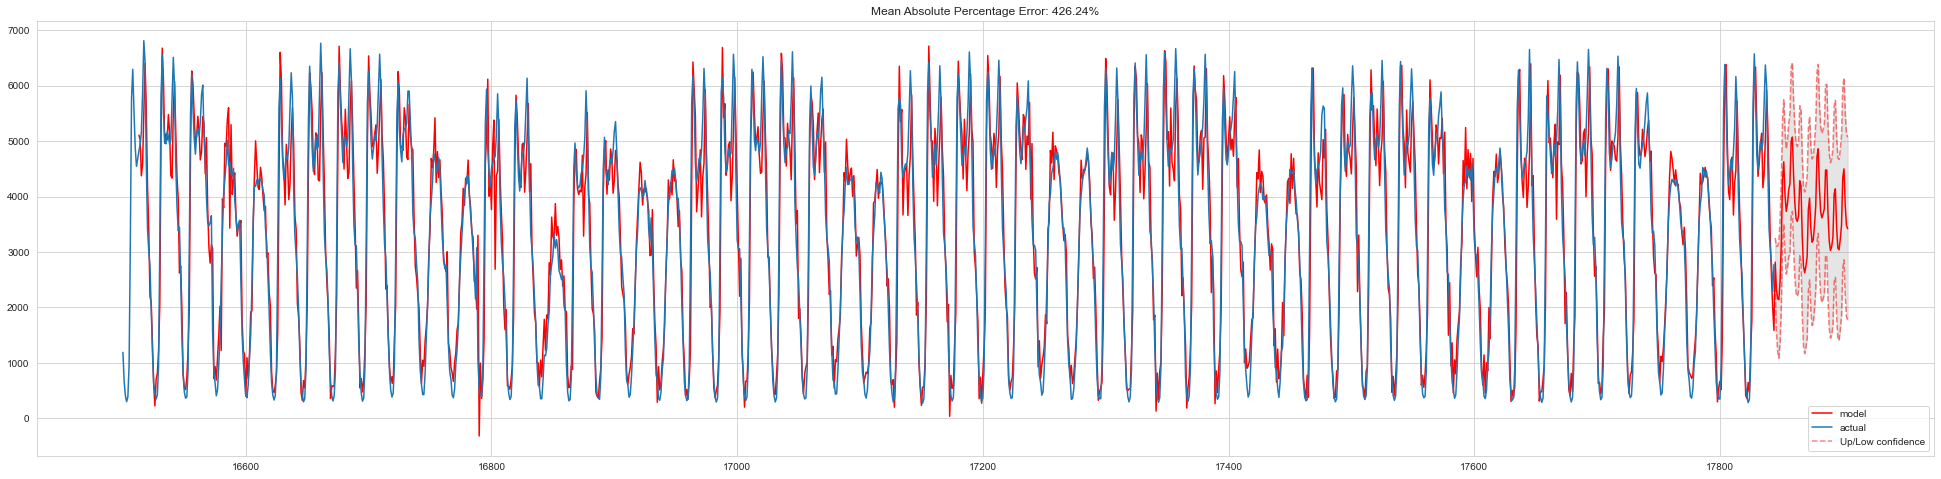

In [302]:
plotSARIMA(Train_Pruned_TS_df.iloc[16500:,:]['traffic_volume'].to_frame(), SARIMAX_tuned_model_results, n_steps=60, s=12, d=1, plot_intervals=True, alpha=0.5)

In [292]:
def optimizeSARIMA(data, parameters_list, d, D, s):
    """
    Return dataframe with parameters and corresponding AIC
    :param parameters_list:  list with (p, q, P, Q) tuples
    :type parameters_list:    list
    :param d:                integration order in ARIMA model
    :type d:                  int
    :param D:                seasonal integration order
    :type D:                  int
    :param s:                length of season
    :type s:                  int
    """
    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(data,
                                              order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']

    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [294]:
%%time

ps = range(2, 4)
d = 1
qs = range(2, 4)
Ps = range(0, 3)
D = 1
Qs = range(0, 3)
s = 12

# creating list with all the possible combinations of parameters
parameters_list = list(product(ps, qs, Ps, Qs))

result_table = optimizeSARIMA(Train_Pruned_TS_df.iloc[16500:,:]['traffic_volume'], parameters_list, d, D, s)

  3%|▎         | 1/36 [00:00<00:08,  3.91it/s]C:\Users\Rost\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  6%|▌         | 2/36 [00:03<01:08,  2.01s/it]C:\Users\Rost\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  8%|▊         | 3/36 [00:10<02:21,  4.29s/it]C:\Users\Rost\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 11%|█         | 4/36 [00:13<01:59,  3.75s/it]C:\Users\Rost\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 17%|█▋        | 6/36 [00:25<02:33,  5.12s/it]C:\Users\Rost\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likeliho

Wall time: 4min 41s


In [ ]:
''' попытка запуска модели optimizeSARIMA ни привела к какому - либо результату. но я заместил эту функцию другой: auto_arima'''

# Попробуем prophet

In [2]:
!pip install prophet

  Using cached prophet-1.1.2-py3-none-win_amd64.whl (12.1 MB)
  Using cached cmdstanpy-1.1.0-py3-none-any.whl (83 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached holidays-0.19-py3-none-any.whl (208 kB)
  Using cached korean_lunar_calendar-0.3.1-py3-none-any.whl (9.0 kB)
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
  Using cached ephem-4.1.4-cp39-cp39-win_amd64.whl (1.4 MB)


In [95]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [165]:

df_fbp = pd.DataFrame()
df_fbp["ds"] = Pruned_TS_df.iloc[:,:]['date_time']
df_fbp["y"] = Pruned_TS_df.iloc[:,:]['traffic_volume']

In [158]:
df_fbp#.head()

ds       y
47646 2018-03-07 09:00:00  5343.0
47647 2018-03-07 10:00:00  4619.0
47648 2018-03-07 11:00:00  4819.0
47649 2018-03-07 12:00:00  4879.0
47650 2018-03-07 13:00:00  5093.0
...                   ...     ...
52624 2018-09-30 19:00:00  3543.0
52625 2018-09-30 20:00:00  2781.0
52626 2018-09-30 21:00:00  2159.0
52627 2018-09-30 22:00:00  1450.0
52628 2018-09-30 23:00:00   954.0

[4973 rows x 2 columns]

In [196]:
fb_y_train = df_fbp.iloc[:-1128].copy()
fb_y_test = df_fbp.iloc[-1128:].copy()
fb_y_val = fb_y_test[["ds"]].copy()

In [197]:
fbmodel = Prophet()
fbmodel.fit(fb_y_train)

forecast = fbmodel.predict(fb_y_val)

20:42:09 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] done processing


In [200]:
forecast['yhat']#.tail()

0       1513.828286
1        838.903371
2        405.026470
3        588.840226
4       1493.879951
           ...     
1123    3298.107837
1124    2590.483911
1125    2125.126504
1126    1841.694464
1127    1516.499568
Name: yhat, Length: 1128, dtype: float64

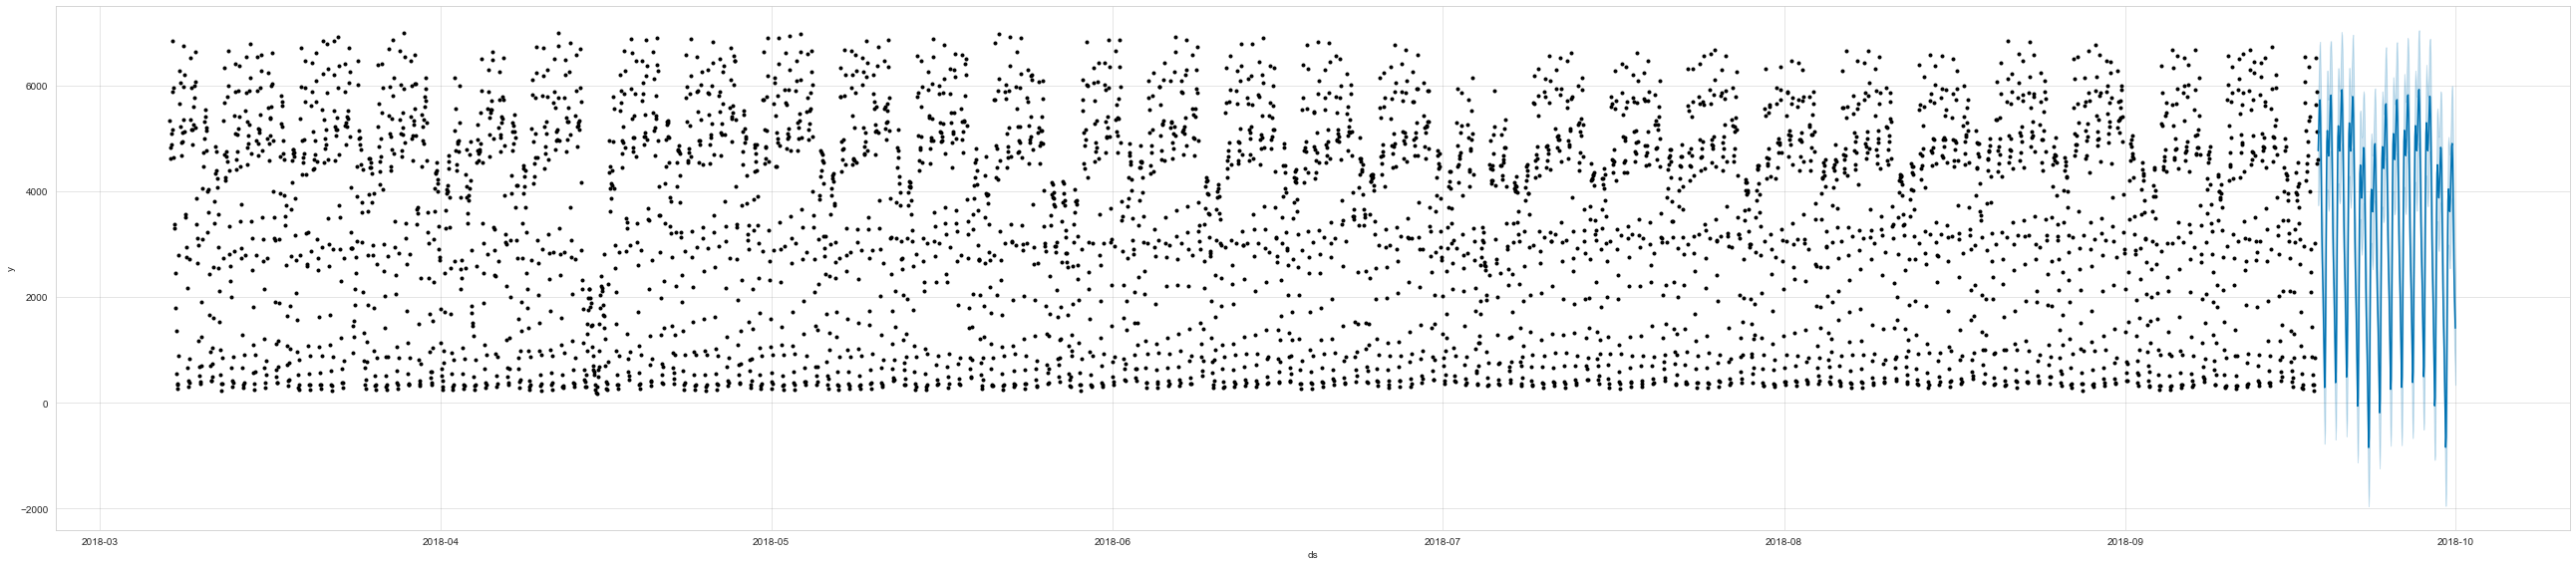

In [162]:
fig2 = fbmodel.plot(forecast, figsize=(36,8))
# plt.plot(fb_y_test.iloc[-50:,:]["ds"], fb_y_test.iloc[-50:,:]["y"], c="r", alpha=0.4)
plt.show()

In [168]:
plot_plotly(fbmodel, forecast)

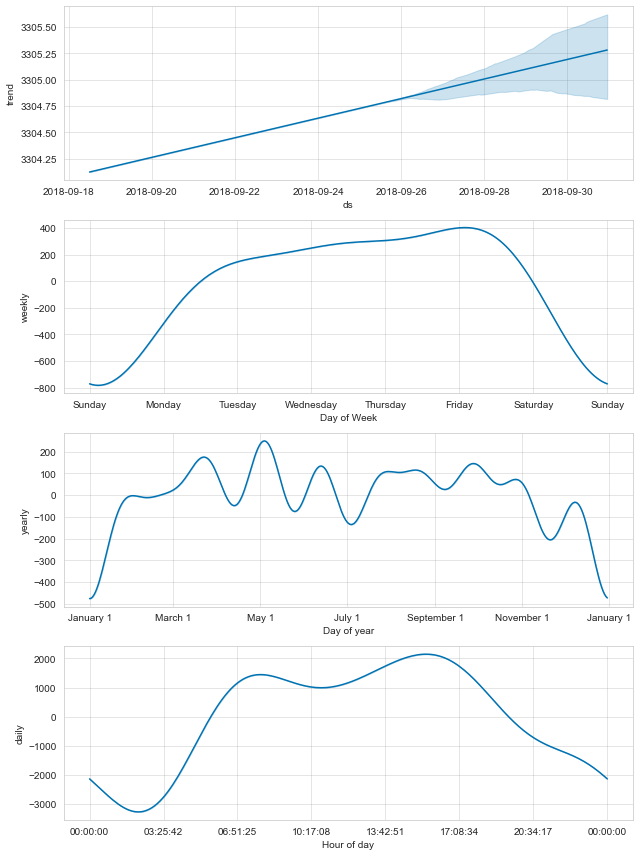

In [169]:
_ = fbmodel.plot_components(forecast)

# Recurrent Forecast!

In [412]:
metro_df = Pruned_TS_df[['traffic_volume','date_time']].copy()
metro_df.set_index('date_time', inplace=True)

In [409]:
def create_lags(df, series_columns, start_lag, end_lag):
    data = df.copy()
    for c in series_columns:
        for i in range(start_lag, end_lag):
            data["lag_{}_{}".format(c, i)] = data[c].shift(i)
    return data


def timeseries_train_test_split(y, X=None, test_size=0.2):
    """
    Performs train-test split with respect to time series structure
    :param X:         x data
    :type X:           pd.DataFrame
    :param y:         y data
    :type y:           pd.Series
    :param test_size: percent of test data from the end of series (0-1)
    :type test_size:   float
    """
    test_index = int(len(y)*(1-test_size))

    if X is None:
        y_train = y.iloc[:test_index]
        y_test = y.iloc[test_index:]
        return y_train, y_test
    else:
        X_train = X.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = X.iloc[test_index:]
        y_test = y.iloc[test_index:]
        return X_train, X_test, y_train, y_test

In [418]:
def recursive_predict(model, df_forecast):
    horizon = len(df_forecast)

    df_pred = df_forecast.copy()
    df_pred.iloc[1:] = np.nan

    forecast = []

    for i in range(horizon):
        next_x = model.predict(df_pred.iloc[[i], :])[0]
        if i < horizon-1:
            df_pred.iloc[i+1,0] = next_x
            df_pred.iloc[[i+1],1:] = df_pred.iloc[i,:-1].values
        forecast.append(next_x)

    return np.array(forecast)


def plotRecursivePrediction(model, X_test, y_test):
    prediction = recursive_predict(model, X_test)

    plt.figure(figsize=(34, 8))

    error = mape(prediction, y_test.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))

    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

In [415]:
data = create_lags(df=metro_df, series_columns=["traffic_volume"], start_lag=1, end_lag=96)

y = data.dropna()["traffic_volume"]
X = data.dropna().drop(["traffic_volume"], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(y, X, test_size=0.3)

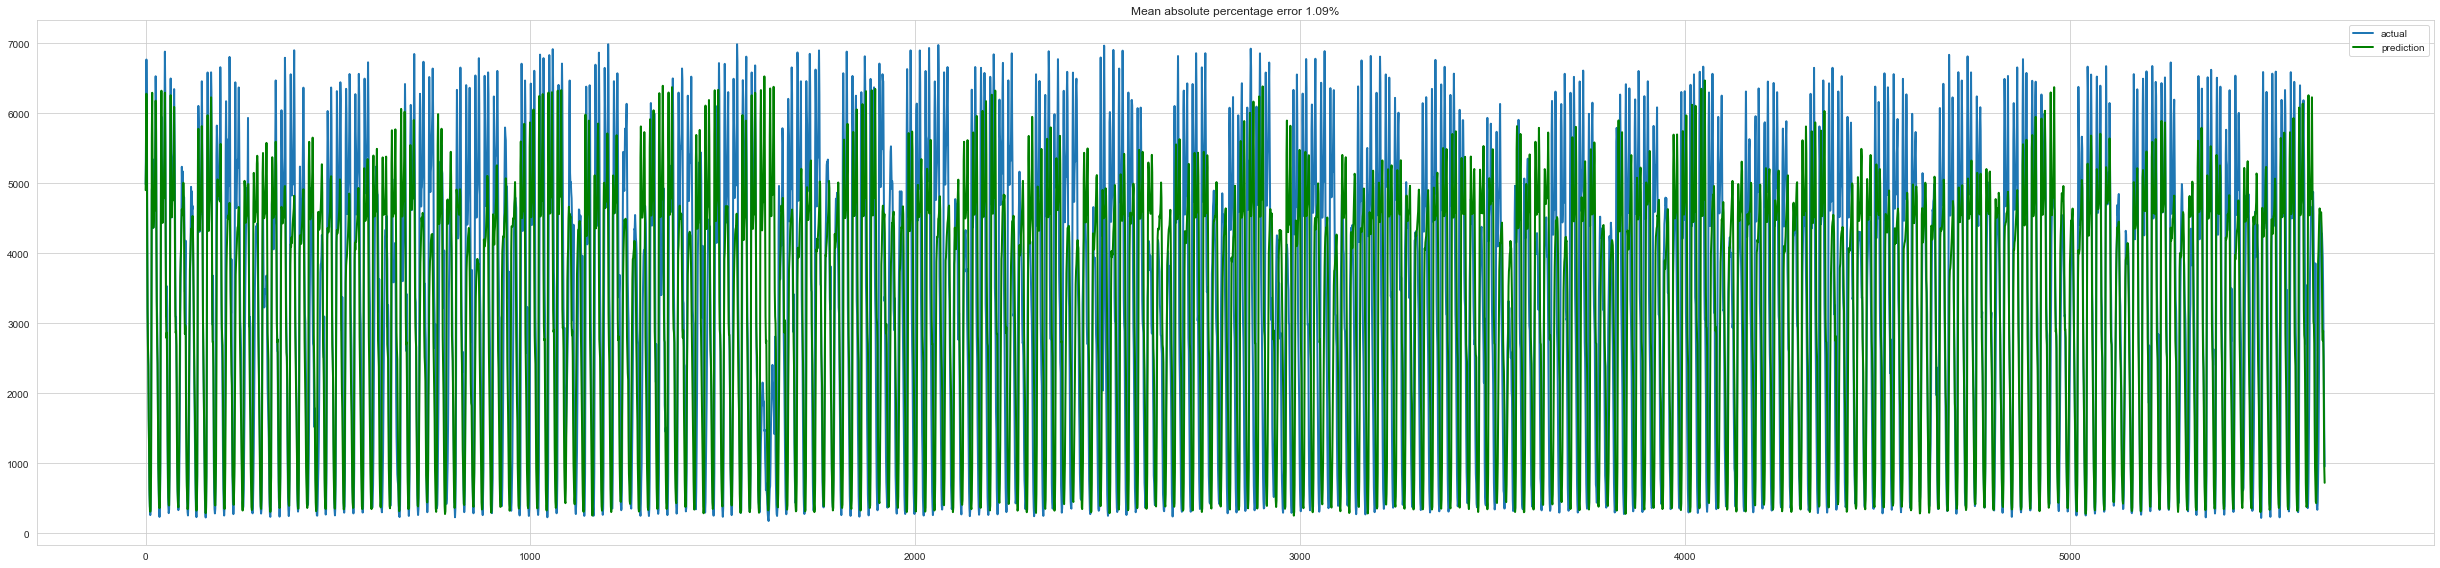

In [427]:
# градиентный бустинг
gb_clf = GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.25, random_state=42)
gb_clf.fit(X_train, y_train)

plotRecursivePrediction(gb_clf, X_test, y_test)

In [433]:
gb_clf = GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.25, random_state=42)
gb_clf.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.25, max_depth=4, n_estimators=200,
                          random_state=42)

In [434]:
gb_predictions = gb_clf.predict(X_test)

# END of  Recurrent Forecast!

# Let's try more features

In [450]:
def create_time_features(data):
    data["hour"] = data.index.hour.values
    data['hour_cos'] = np.cos(2 * np.pi * data["hour"].values / 23)
    data['hour_sin'] = np.sin(2 * np.pi * data["hour"].values / 23)
    data["is_weekend"] = data.index.weekday.isin([5,6]).astype(int)
    return data


class MeanEncoder:
    def __init__(self, y_col, cat_feat):
        self.y_col = y_col
        self.cat_feat = cat_feat
        self.mean_codes = None

    def fit(self, data):
        cols = [self.y_col] + self.cat_feat
        self.mean_codes = data[cols].groupby(self.cat_feat).mean().to_dict()[self.y_col]

    def get_period_means(self, data):
        return data[self.cat_feat].apply(self._encode_with_mean, axis=1)

    def _encode_with_mean(self, row):
        key = tuple(row)
        val = self.mean_codes[key]
        return val


class LagEncoder:
    def __init__(self, start_lag, end_lag):
        self.start_lag = start_lag
        self.end_lag = end_lag
        self.lag_columns = []
        for i in range(self.start_lag, self.end_lag+1):
            col_name = "lag_{}".format(i)
            self.lag_columns.append(col_name)

    def get_lags(self, series):
        df_lags = pd.DataFrame(index=series.index)
        for i in range(self.start_lag, self.end_lag+1):
            col_name = self.lag_columns[i-1]
            df_lags[col_name] = series.shift(i)
        return df_lags

In [457]:
# функция для запуска процесса формирования лагов
def prepare_data_from_1D_series(series):
    df_series = pd.DataFrame(series)
    df_series.index = pd.to_datetime(df_series.index)

    df_lags = lag_encoder.get_lags(series)
    data = pd.concat([df_series, df_lags], axis=1)

    data = create_time_features(data)

    mean_encoder.fit(data)
    data["mean_code"] = mean_encoder.get_period_means(data)

    data.dropna(inplace=True)

    data.loc[:,:] = scaler.fit_transform(data)

    feat_cols = data.columns.tolist()
    feat_cols.remove("traffic_volume")

    Y = data["traffic_volume"]
    X = data[feat_cols]

    forecast_start_X = data.loc[data.index[-1],["traffic_volume"] + lag_encoder.lag_columns[:-1]]
    forecast_start_X.index = lag_encoder.lag_columns

    return X, Y, feat_cols, forecast_start_X

In [475]:
# построить датафрейм для тестовых данных
def create_forecast_timestamp(series, forecast_horizon):
    t2 = pd.to_datetime(series.index[-1])
    t1 = pd.to_datetime(series.index[-2])
    delta = t2 - t1
    t_index = [t2 + delta]
    for _ in range(forecast_horizon-1):
        t_index.append(t_index[-1] + delta)
    return t_index


def build_forecast_df(series, feat_cols, forecast_start_X, forecast_horizon):
    t_index = create_forecast_timestamp(series, forecast_horizon=forecast_horizon)
    forecast_df = pd.DataFrame(columns=["traffic_volume"]+feat_cols, index=t_index)

    forecast_df = create_time_features(forecast_df)
    forecast_df["mean_code"] = mean_encoder.get_period_means(forecast_df)

    forecast_df.iloc[:,:] = scaler.transform(forecast_df)

    forecast_df.loc[t_index[0], lag_encoder.lag_columns] = forecast_start_X.values
    return forecast_df

In [511]:
def recursive_predict(model, df_forecast):
    horizon = len(df_forecast)
    df_pred = df_forecast.copy()
    forecast = []
    lagcols = lag_encoder.lag_columns
    t = df_forecast.index

    feat_cols = df_forecast.columns.tolist()
    feat_cols.remove("x")

    for i in range(horizon):
        timestamp = t[i]
        next_x = model.predict(df_pred.loc[[timestamp], feat_cols])[0]
        if i < horizon-1:
            next_timestamp = t[i+1]
            df_pred.loc[next_timestamp, lagcols[0]] = next_x
            df_pred.loc[next_timestamp, lagcols[1:]] = df_pred.loc[timestamp, lagcols[:-1]].values
        forecast.append(next_x)

    df_pred.loc[:, "x"] = forecast
    df_pred.loc[:,:] = scaler.inverse_transform(df_pred)
    return df_pred


def plotRecursivePrediction(y_test, y_forecast):
    plt.figure(figsize=(15, 7))

    error = mape(y_forecast.values, y_test.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))

    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(y_forecast.values, "g", label="prediction", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model, X_train):
    """
    Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [512]:
series_train, series_test = timeseries_train_test_split(metro_df.iloc[:,:], test_size=0.3)

mean_encoder = MeanEncoder(y_col="traffic_volume", cat_feat=["hour", "is_weekend"])
scaler = StandardScaler()
lag_encoder = LagEncoder(start_lag=1, end_lag=30)

In [513]:
from sklearn.linear_model import LinearRegression

In [514]:
X_train, y_train, feat_cols, forecast_start_X = prepare_data_from_1D_series(series_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [515]:
len(X_train.columns)

35

In [516]:
# линейная регрессия
df_forecast = build_forecast_df(series_train, feat_cols, forecast_start_X, forecast_horizon=len(series_test))

In [517]:
df_forecast.info

<bound method DataFrame.info of                      traffic_volume     lag_1     lag_2     lag_3     lag_4  \
2018-02-05 10:00:00             NaN  0.823017  1.417326  1.406237  0.799357   
2018-02-05 11:00:00             NaN       NaN       NaN       NaN       NaN   
2018-02-05 12:00:00             NaN       NaN       NaN       NaN       NaN   
2018-02-05 13:00:00             NaN       NaN       NaN       NaN       NaN   
2018-02-05 14:00:00             NaN       NaN       NaN       NaN       NaN   
...                             ...       ...       ...       ...       ...   
2018-09-30 09:00:00             NaN       NaN       NaN       NaN       NaN   
2018-09-30 10:00:00             NaN       NaN       NaN       NaN       NaN   
2018-09-30 11:00:00             NaN       NaN       NaN       NaN       NaN   
2018-09-30 12:00:00             NaN       NaN       NaN       NaN       NaN   
2018-09-30 13:00:00             NaN       NaN       NaN       NaN       NaN   

                   

In [502]:
df_forecasted = recursive_predict(lr, df_forecast)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [486]:
plotRecursivePrediction(series_test.traffic_volume, df_forecasted.traffic_volume)

NameError: name 'df_forecasted' is not defined

с добавлением фичей ничего не вышло, полезли наны, откуда - не понятно. Однако, т.к. градиентный бустингг себя уже хорошо показал, тратить время на траблшутинг - не целесообразно.

# Lets make a Dataframe with metrics!

In [382]:
SARIMAX_pred_mean = SARIMAX_pred_mean.to_frame().reset_index(drop=True)

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [388]:
df_test = Test_Pruned_TS_df[['traffic_volume', 'traffic_volume_pred_mean']].copy()

In [389]:
df_test['Prophet'] = forecast['yhat']

In [390]:
df_test['Sarima'] = SARIMAX_pred_mean['predicted_mean']

In [392]:
df_test = df_test.rename(columns={'traffic_volume_pred_mean': 'Baseline'})

In [443]:
df_test['GB'] = gb_predictions[-1128:]

In [445]:
df_test

traffic_volume     Baseline      Prophet       Sarima           GB
0              793.0   625.783019  1513.828286  2816.711212  1657.740768
1              492.0   393.009434   838.903371  2332.755149   486.126682
2              335.0   309.891509   405.026470  2154.835590   384.098357
3              403.0   376.962264   588.840226  2141.071147   345.778096
4              948.0   904.759434  1493.879951  2492.716869   906.110990
...              ...          ...          ...          ...          ...
1123          3543.0  3169.933962  3298.107837  3216.411872  3534.688225
1124          2781.0  2824.560748  2590.483911  3344.262946  3184.665674
1125          2159.0  2372.556604  2125.126504  3537.948909  2452.408466
1126          1450.0  1825.566038  1841.694464  4332.549929  1847.892052
1127           954.0  1232.205607  1516.499568  4424.201181  1115.122306

[1128 rows x 5 columns]

In [405]:
metrics_df = pd.DataFrame(columns=['Baseline', 'Prophet', 'Sarima'], index=['RMSE', 'MAE', 'MAPE', 'Percentage_error'])

In [396]:
metric_model = ['RMSE', 'MAE', 'MAPE', 'Percentage_error']

In [402]:
def make_metrics(metric, column):

    metric = metric.lower()

    if metric == 'percentage_error':
        value = 100 * np.mean(np.abs((df_test['traffic_volume'] - df_test[column]) / df_test['traffic_volume']))
    elif metric == 'mse':
        value = np.sqrt(mse(df_test['traffic_volume'], df_test[column]))
    elif metric == 'mae':
        value = mae(df_test['traffic_volume'], df_test[column])
    else:
        value = mape(df_test['traffic_volume'], df_test[column])

    result = round(value, 2)

    return result

In [446]:
for mm in metric_model:
    for i in df_test.columns[1:]:
        metrics_df.loc[mm , i] = make_metrics(mm, i)

In [447]:
metrics_df

Baseline Prophet   Sarima      GB
RMSE                 0.09    0.37      1.8    0.07
MAE                222.17  586.92  1703.39  160.89
MAPE                 0.09    0.37      1.8    0.07
Percentage_error     8.99   37.11    180.3    6.98

In [ ]:
# Ошибка выросла, по сравнению с бейзлайном у proohet и sarima, однако градиентный бустинг оказался лучше!